In [ ]:
# random forest classifier 
# hyper parameter 
# grid search cv 
# autoencoder? (oversampling된 데이터)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [161]:
data = pd.read_csv("ins_fraud.csv")

In [212]:
len(data.columns)

25

In [12]:
data.isnull().sum()

fraud_YN                 0
car_model                0
sharing_type             0
age_group                0
has_previous_accident    0
cumulative_use_count     0
b2b                      0
accident_ratio           0
pf_type                  0
socarpass                0
socarsave                0
start_hour               0
duration                 0
accident_hour            0
repair_cost              0
insure_cost              0
accident_location        0
car_part1                0
car_part2                0
repair_cnt               0
acc_type1                0
insurance_site_aid_YN    0
police_site_aid_YN       0
total_prsn_cnt           0
test_set                 0
dtype: int64

In [10]:
# 결측치가 없다 

In [14]:
data

,fraud,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,0,2,1,3,0,2,0,100,2,0,...,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,...,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,...,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,...,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,...,1209410,1,0,0,2,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,2,0,2,0,2,0,100,2,0,...,0,1,1,0,1,0,0,0,-1,0
15996,0,2,0,2,1,4,0,100,1,1,...,0,2,1,0,1,0,0,0,-1,0
15997,0,2,1,2,0,4,0,100,1,0,...,0,0,0,0,1,0,0,0,-1,1
15998,0,2,0,2,0,2,0,100,2,0,...,0,4,1,0,1,0,0,0,-1,0


In [13]:
'''
fraud:1 if fraud 0 if not 
c1 '경형','소형','소형SUV' : 1 / '준중형','준중형SUV','중형' : 2 / '대형','승합','준대형','중형SUV' : 3 / '수입' : 4 / 'EV','RV' : 5
c2부름: 1, 쏘카: 0 (?)
c3 age 21 : 1 / 23 : 2 / 27 : 3 / 31 : 4 / 41 : 5
c4 누적 사고 유무 : 1 if yes, 0 if not
c5 누적 대여 횟수 1 : 1 / (2,3,4,5) : 2 / (6,7,8,9,10) : 3 / 10+ : 4 / else 0
c6 법인이용 개인 고객 = 0 / 법인 = 1 / 법인 구성원 = 2
c7 과실율 unique = 100,   0,  90,  55,  30,  80,  40,  10,  70,  20,  60,  85,  75, 50,  15,  65,  25
c8 보험료 타입 선택 PF5 : 1 / PF30 : 2 / PF70 : 3 / else 0
c9 쏘카패스: yes 1 no 0
c10 쏘카세이브: yes 1 no 0 
c11 이용시작시간: (0,1,2,3,4,21,22,23) : 1 / (17,18,19,20) : 2 / (5,6,7) : 3 / (8,9,10) : 4 / (11,12,13) : 5 / (14,15,16) : 6
c12 대여기간 (2,3,4,5) : 1 / (6,7,8,9) : 2 / (10 =< x <=36) : 3 / (36+) : 4 / (0,1) : 5
c13 사고시각 (0,1,2,3,4,21,22,23) : 1 / (17,18,19,20) : 2 / (5,6,7) : 3 / (8,9,10) : 4 / (11,12,13) : 5 / (14,15,16) : 6 / else -1
c14 차량수리비용
c15 보험손해비용
c16 사고위치: 0주차장 1일반도로 2이면도로 3고속도로 4쏘카존 5확인불가
c17 전면 손상 if(a1 = 1, 1, 0) a1, -- 앞범퍼
c18 후면 손상 if(a10 = 1, 1, 0) a10, -- 뒷범퍼
c19 수리 부위 갯수
c20 사고타입: 사고 유형1 : 차대인(10) 차대차(20) 차량단독(30) 보행중(40) 자전거(50) 기타(99)
c21 보험사 현장출동 유무 Yes 1 no 2 else 0 
c22 경찰 현장출동 유무 1 미신고 / 2 신고 / else 0
c23 우리차 탑승 인원 ("0","1","2","3","4"), 5이상: 5, 미확인=-1 
c24 test_set
'''

"\nfraud_YN:1 if fraud 0 if not \n\ncar_model 차종: \n    '경형','소형','소형SUV' : 1\n    '준중형','준중형SUV','중형' : 2\n    '대형','승합','준대형','중형SUV' : 3\n    '수입' : 4\n    'EV','RV' : 5\n\nsharing_type:부름 / 쏘카\n    부름: 1, 쏘카: 0 (?)\n     \nage_group 연령대\n    21 : 1\n    23 : 2\n    27 : 3\n    31 : 4\n    41 : 5\n\nhas_previous_accident 누적 사고 유무 : 1 if yes, 0 if not\n    \ncumulative_use_count 누적 대여 횟수\n    1 : 1\n    (2,3,4,5) : 2\n    (6,7,8,9,10) : 3\n    10+ : 4\n    else 0\n    \nb2b 법인이용\n    개인 고객 = 0\n    법인 = 1\n    법인 구성원 = 2\n\naccident_ratio 과실율\n    unique = 100,   0,  90,  55,  30,  80,  40,  10,  70,  20,  60,  85,  75, 50,  15,  65,  25\n    \npf_type 보험료 타입 선택 (PF5, PF30, PF70)\n    PF5 : 1\n    PF30 : 2\n    PF70 : 3\n    else 0\n\nsocarpass 쏘카패스: yes 1 no 0\n\nsocarsave 쏘카세이브: yes 1 no 0 \n    \nstart_hour 이용시작시간: \n    (0,1,2,3,4,21,22,23) : 1\n    (17,18,19,20) : 2\n    (5,6,7) : 3\n    (8,9,10) : 4\n    (11,12,13) : 5\n    (14,15,16) : 6\n\nduration 대여기간\n    (2,3,4,5) : 1\n  

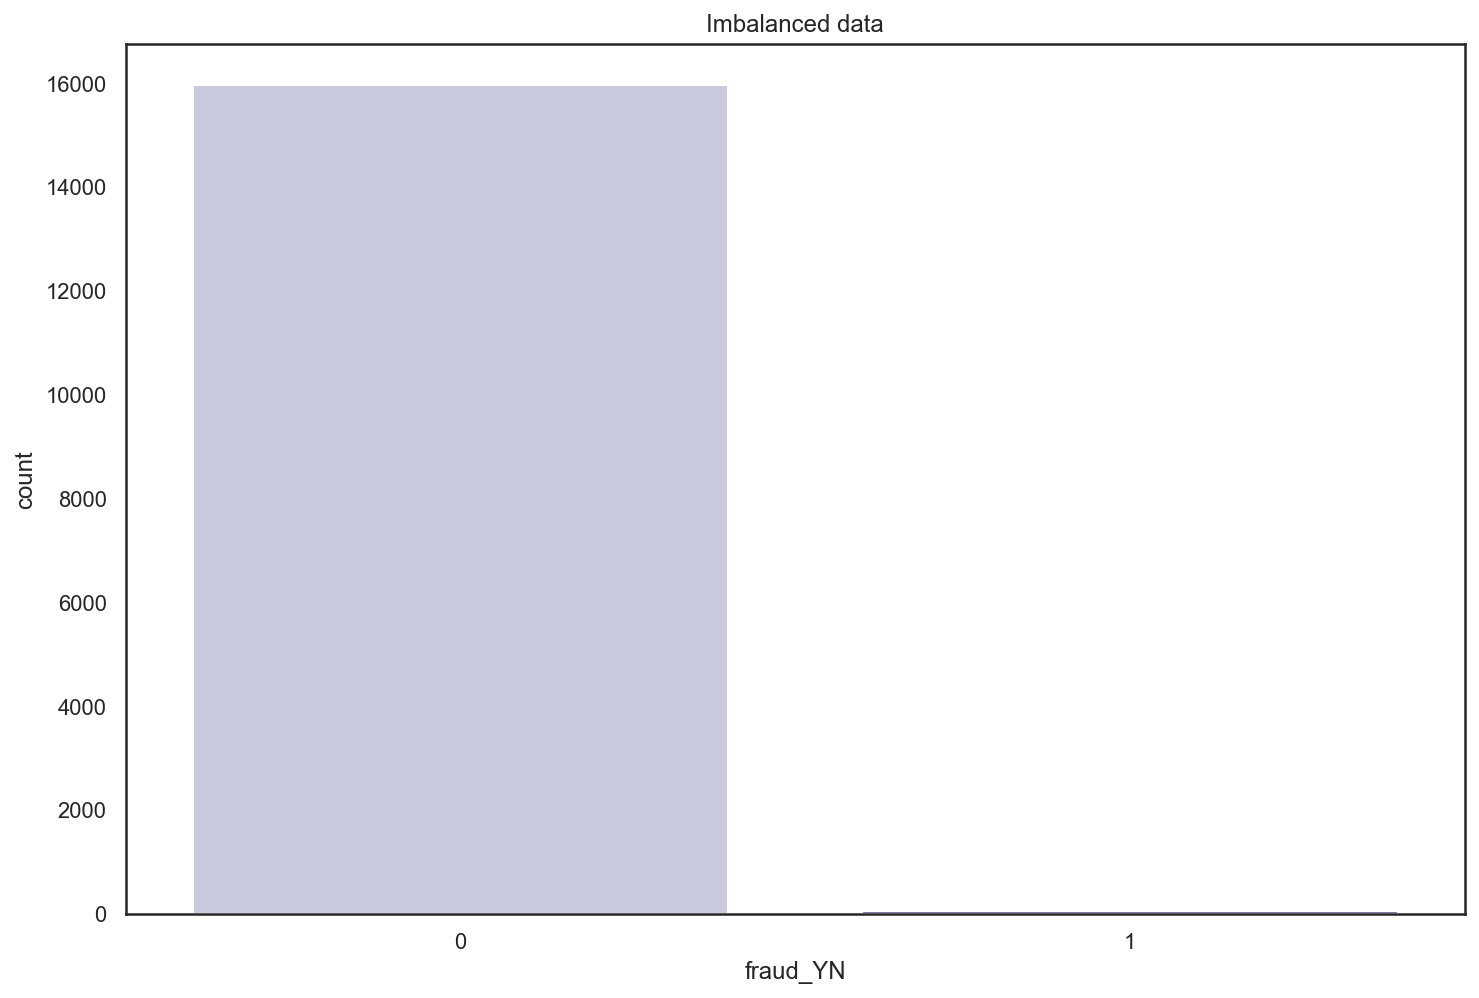

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Imbalanced data')
sns.countplot(data["fraud_YN"], palette="Purples")
plt.show()

In [ ]:
# EDA 진행  - on a separate workbook 

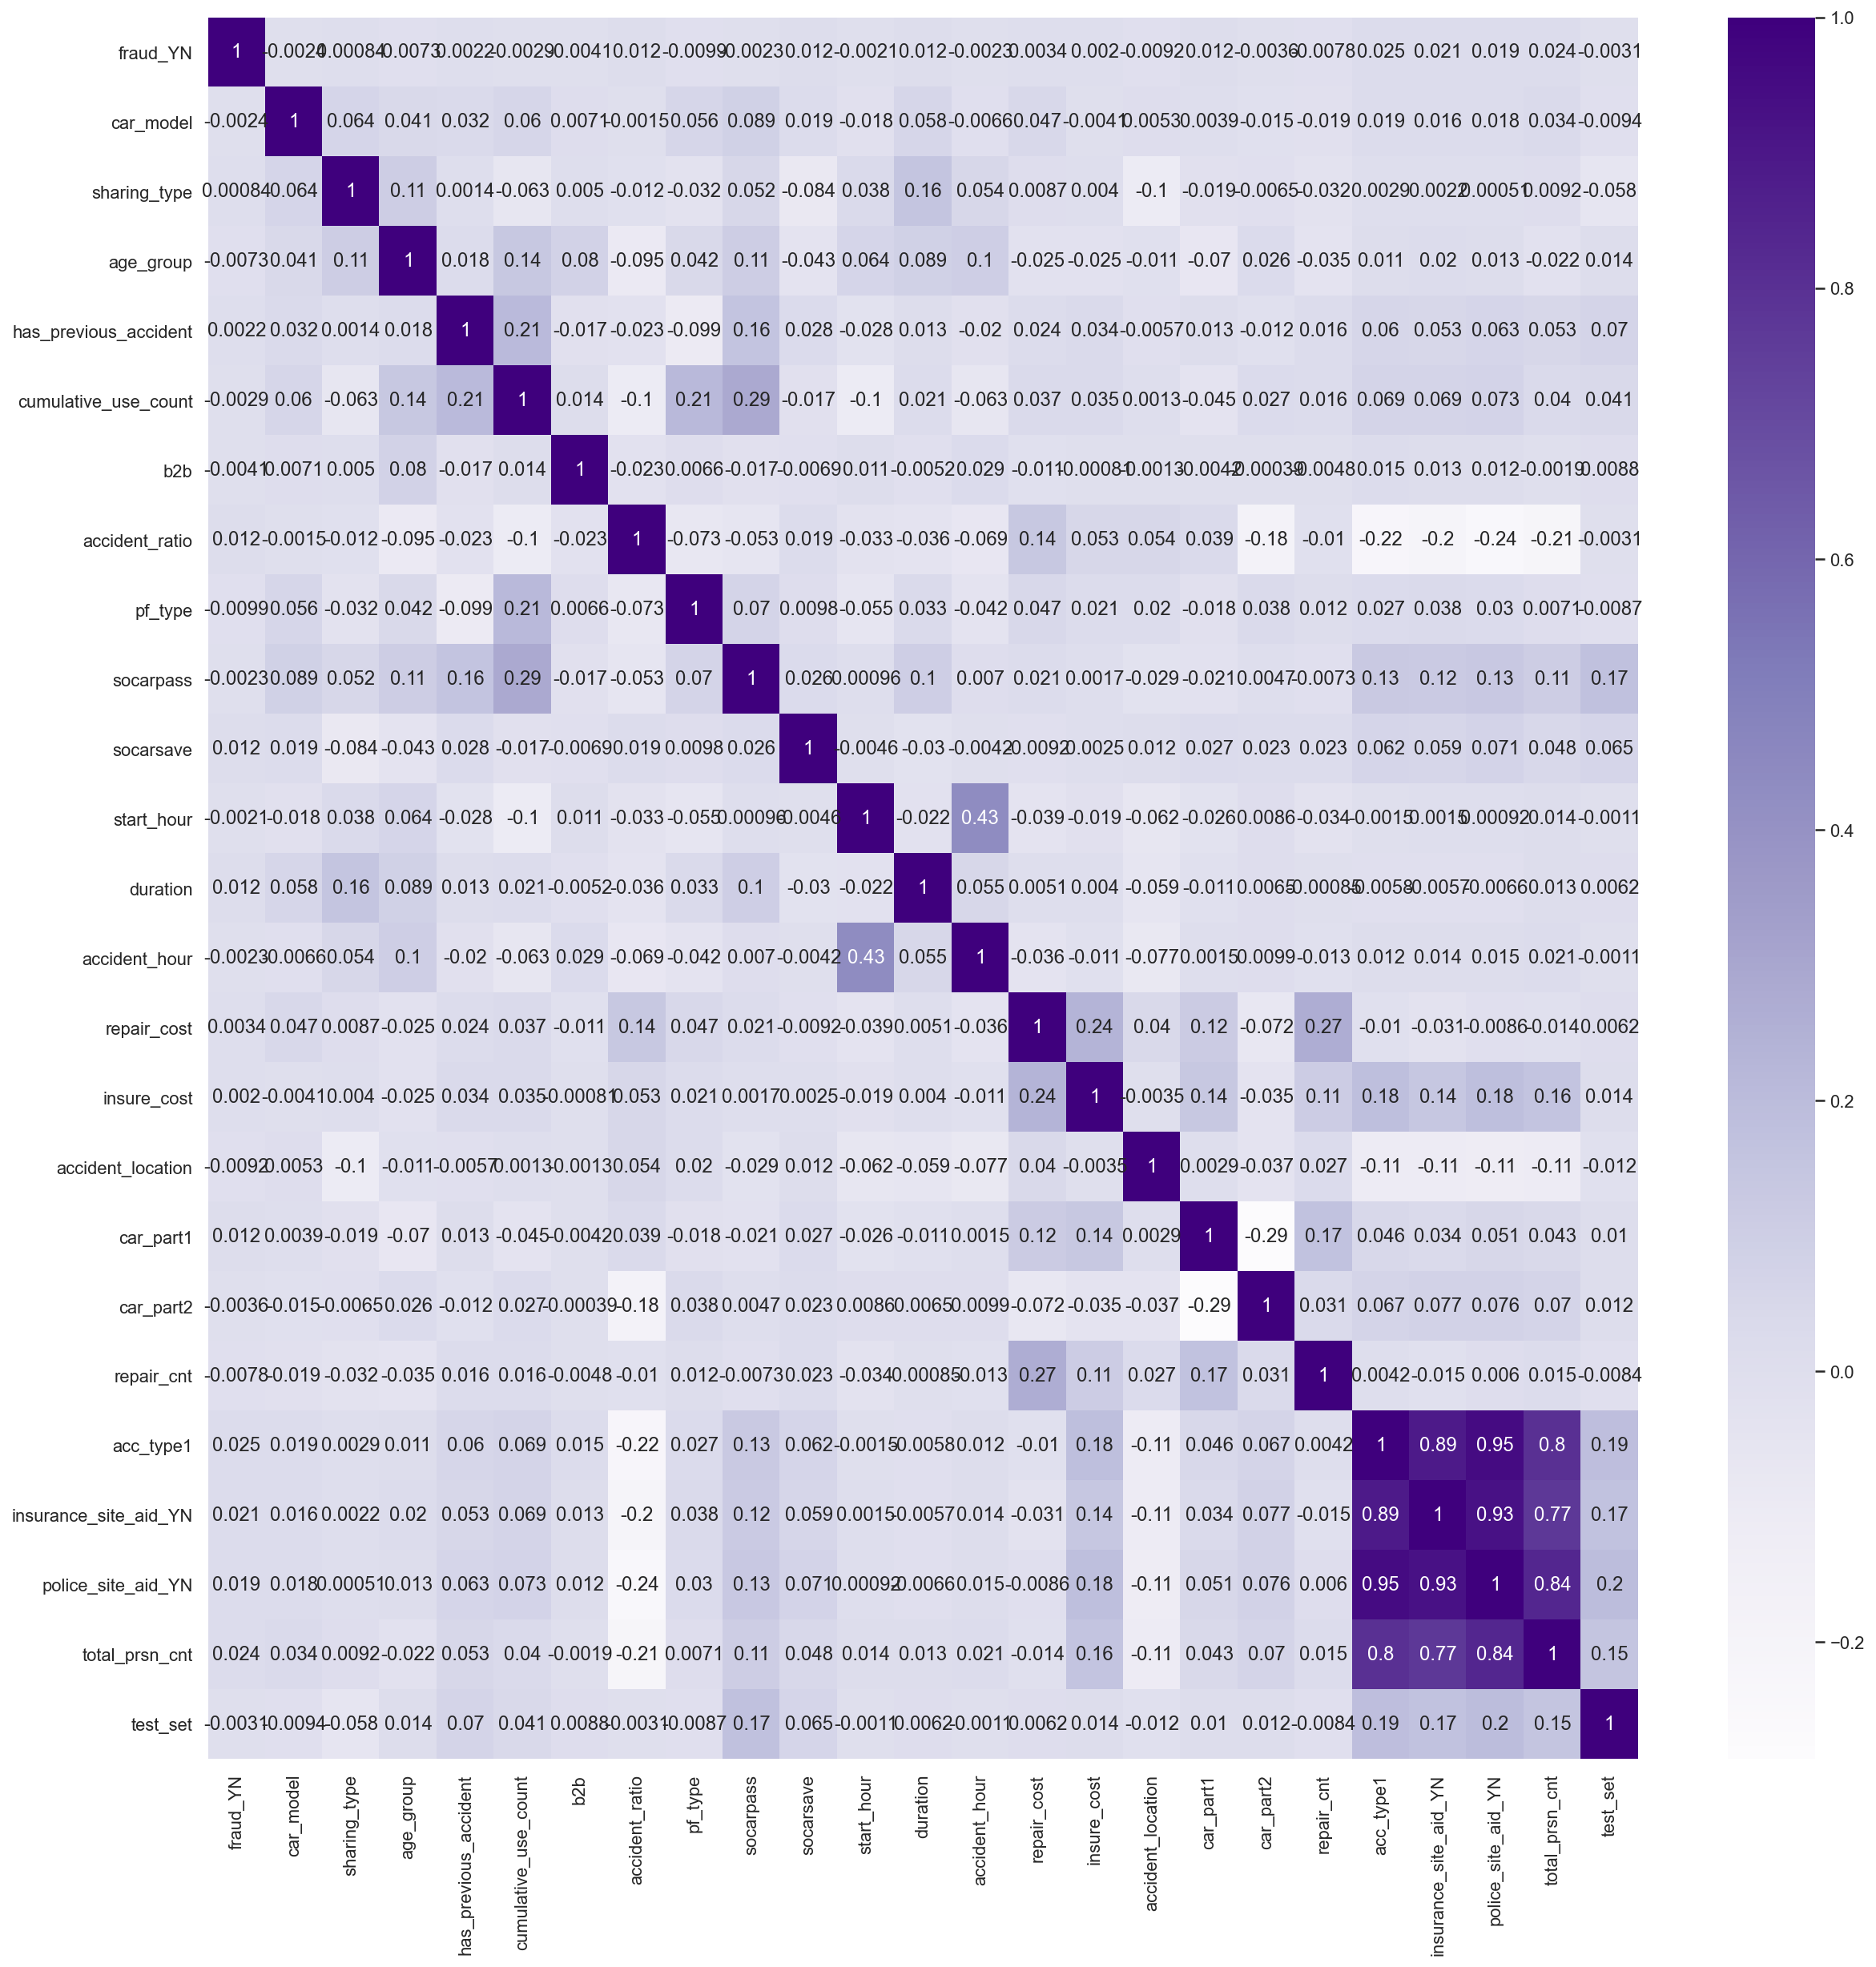

In [79]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), cmap="Purples", annot=True)
plt.show()

# UNDERSAMPLING & OVERSAMPLING

# UNDERSAMPLING

### RandomUnderSampler

In [449]:
# 맞춰야하는 테스ㅡㅌ 데이터의 fraud는 7개 
len(data[(data['c24']==1)&(data['fraud']==1)][["fraud"]])

7

In [21]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [453]:
X_train

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
1,1,0,4,0,4,0,0,3,1,0,...,0.000000e+00,0,1,1,1,2,1,1,1,0
2,1,0,4,1,4,0,100,3,1,0,...,2.581306e+05,12925040,3,1,0,2,1,1,1,0
5,2,1,3,0,1,0,100,1,0,1,...,0.000000e+00,4777030,1,1,0,1,1,1,1,0
7,3,1,3,0,4,0,100,3,1,0,...,2.680625e+05,250000,2,0,0,1,1,1,1,1
9,2,0,4,0,4,0,100,1,0,1,...,5.973138e+05,0,2,1,0,1,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15978,1,0,2,0,4,0,100,3,0,0,...,0.000000e+00,1708720,0,0,0,1,1,1,1,1
15983,2,0,1,0,4,0,100,3,0,0,...,0.000000e+00,0,4,1,0,1,0,0,0,-1
15984,2,0,2,0,1,0,100,1,0,0,...,3.498486e+05,810230,0,0,0,1,1,1,1,1
15992,2,0,2,0,2,0,100,3,0,0,...,1.086347e+06,0,4,0,0,2,0,0,0,-1


In [23]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [455]:
len(X_res), len(y_res)

(68, 68)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_res, y_res, test_size = 0.10, random_state = 31)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_res, y_res)
 
# 예측
y_pred = forest.predict(X_test)
 
# 정확도 확인
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

print('precision', metrics.precision_score(y_test, y_pred))

print('recall', metrics.recall_score(y_test, y_pred))

print('f1', metrics.f1_score(y_test, y_pred))

정확도 : 1.0
precision 1.0
recall 1.0
f1 1.0


In [27]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.20      1.00      0.33         1

    accuracy                           0.43         7
   macro avg       0.60      0.67      0.42         7
weighted avg       0.89      0.43      0.48         7



0.42857142857142855

In [28]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 983, 2131],
       [   3,    4]])

In [ ]:
# 하지만 데이터가 너무 적어서 유의미하다고 판단하기 어렵다.... 

### Tomek’s link method

In [29]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [30]:
from imblearn.under_sampling import TomekLinks
tom = TomekLinks()
X_tom, y_tom = tom.fit_resample(X, y)

In [31]:
len(X_tom), len(y_tom)

(12861, 12861)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_tom, y_tom, test_size = 0.10, random_state = 31)

In [33]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1284
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1287
   macro avg       0.50      0.50      0.50      1287
weighted avg       1.00      1.00      1.00      1287



0.9976689976689976

In [34]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.9976689976689976
precision 0.0
recall 0.0
f1 0.0


In [35]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3114,    0],
       [   7,    0]])

### Condensed Nearest Neighbour

In [36]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [37]:
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour(random_state=42)
X_cnn, y_cnn = cnn.fit_resample(X, y)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_cnn, y_cnn, test_size = 0.10, random_state = 31)

In [39]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        26
           1       0.00      0.00      0.00         7

    accuracy                           0.79        33
   macro avg       0.39      0.50      0.44        33
weighted avg       0.62      0.79      0.69        33



0.7878787878787878

In [40]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.7878787878787878
precision 0.0
recall 0.0
f1 0.0


In [41]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3113,    1],
       [   7,    0]])

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_test, y_test)
 
# 예측
y_pred = forest.predict(X_test)

# 정확도 확인
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

print('precision', metrics.precision_score(y_test, y_pred))

print('recall', metrics.recall_score(y_test, y_pred))

print('f1', metrics.f1_score(y_test, y_pred))

정확도 : 1.0
precision 1.0
recall 1.0
f1 1.0


### One Sided Selection

In [43]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [44]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_oss, y_oss = oss.fit_resample(X, y)

In [45]:
len(X_oss), len(y_oss)

(12802, 12802)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_oss, y_oss, test_size = 0.10, random_state = 31)

In [47]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1278
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1281
   macro avg       0.50      0.50      0.50      1281
weighted avg       1.00      1.00      1.00      1281



0.9976580796252927

In [48]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.9976580796252927
precision 0.0
recall 0.0
f1 0.0


In [49]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3114,    0],
       [   7,    0]])

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_test, y_test)
 
# 예측
y_pred = forest.predict(X_test)
 
# 정확도 확인
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

print('precision', metrics.precision_score(y_test, y_pred))

print('recall', metrics.recall_score(y_test, y_pred))

print('f1', metrics.f1_score(y_test, y_pred))

정확도 : 1.0
precision 1.0
recall 1.0
f1 1.0


### Edited Nearest Neighbours

In [51]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [52]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
X_enn, y_enn = enn.fit_resample(X, y)

In [480]:
len(X_enn), len(y_enn)

(3084, 3084)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_sme, y_sme, test_size = 0.10, random_state = 31)

In [54]:
len(X), len(y)

(12879, 12879)

In [55]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       851

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582



0.9987357774968394

In [56]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.9987357774968394
precision 0.9988249118683902
recall 0.9988249118683902
f1 0.9988249118683902


In [57]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3107,    7],
       [   7,    0]])

In [481]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_enn, y_enn)
 
# 예측x
y_pred = forest.predict(X_test)

 
# 정확도 확인
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

print('precision', metrics.precision_score(y_test, y_pred))

print('recall', metrics.recall_score(y_test, y_pred))

print('f1', metrics.f1_score(y_test, y_pred))

정확도 : 0.9973600434816368
precision 0.0
recall 0.0
f1 0.0


### Neighbourhood Cleaning Rule

In [58]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [59]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5)
X_ncr, y_ncr = ncr.fit_resample(X, y)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_ncr, y_ncr, test_size = 0.10, random_state = 31)

In [62]:
len(X_cr), len(y_ncr)

(12709, 12709)

In [63]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1268
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1271
   macro avg       0.50      0.50      0.50      1271
weighted avg       1.00      1.00      1.00      1271



0.997639653815893

In [64]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.997639653815893
precision 0.0
recall 0.0
f1 0.0


In [65]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3114,    0],
       [   7,    0]])

# Oversampling

### SMOTE

In [ ]:
data = pd.read_csv("ins_fraud.csv")

In [162]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [163]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [164]:
len(X_smote), len(y_smote)

(25690, 25690)

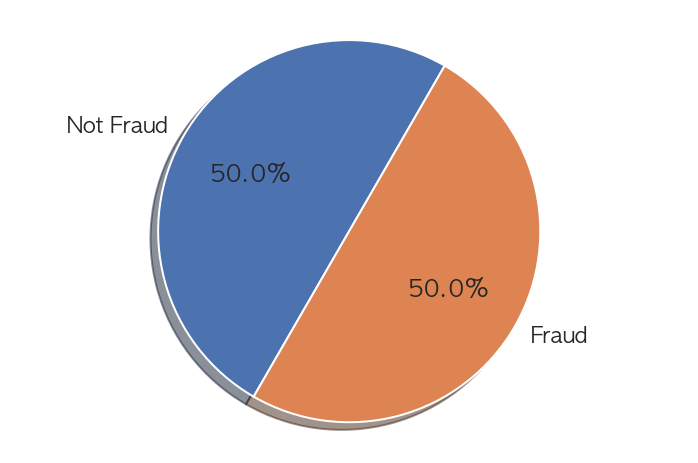

In [388]:
labels = 'Not Fraud', 'Fraud'
explode = (0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(y_smote.value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60)
ax1.axis('equal')
plt.show()

In [492]:
len(x_train), len(x_test), len(y_train), len(y_test)

(5605, 623, 3121, 12879)

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_smote, y_smote, test_size = 0.10, random_state = 31)

In [72]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1285
           1       1.00      1.00      1.00      1284

    accuracy                           1.00      2569
   macro avg       1.00      1.00      1.00      2569
weighted avg       1.00      1.00      1.00      2569



0.9988322304398599

In [73]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.9988322304398599
precision 1.0
recall 0.9976635514018691
f1 0.9988304093567251


In [74]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3112,    2],
       [   7,    0]])

In [75]:
## applying other models
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

models = []

models.append(("Random Forest Classifier: ", RandomForestClassifier()))
models.append(("Decision Tree Classifier: ", DecisionTreeClassifier()))
models.append(("AdaBoost Classifier: " , AdaBoostClassifier()))
models.append(("Gradient Boosting Classifier: ", GradientBoostingClassifier()))
models.append(("Logistic Regression: ", LogisticRegression()))

In [76]:
from sklearn.model_selection import KFold, cross_val_score

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train,
                                cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    print(name, cv_results.mean(), cv_results.std())

Random Forest Classifier:  0.9980104180304872 0.0011557794122022103
Decision Tree Classifier:  0.9925177312260358 0.001960667645954414
AdaBoost Classifier:  0.9123741419620313 0.0025121505613597724
Gradient Boosting Classifier:  0.9634965959038624 0.002433256929740113
Logistic Regression:  0.4739425792574582 0.02233488979835631


In [78]:
# applying logistic regression
rfc = RandomForestClassifier(random_state = 4)
rfc.fit(X_train , y_train)
rfc.score(X_test, y_test)

0.9984429739198132

In [79]:
from sklearn.metrics import classification_report
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1285
           1       1.00      1.00      1.00      1284

    accuracy                           1.00      2569
   macro avg       1.00      1.00      1.00      2569
weighted avg       1.00      1.00      1.00      2569



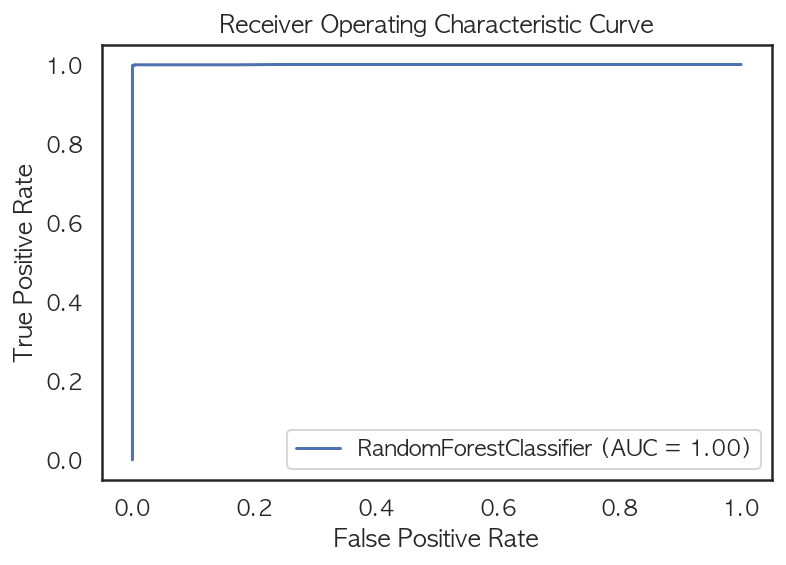

In [80]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rfc, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve');

In [81]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1284,    1],
       [   3, 1281]])

In [82]:
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3111,    3],
       [   7,    0]])

In [91]:
#KNeighborsClassifier? 

In [84]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
classifier = classifier.fit(X_train, y_train)

In [85]:
y_pred = classifier.predict(X_test)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1285
           1       0.82      0.80      0.81      1284

    accuracy                           0.81      2569
   macro avg       0.81      0.81      0.81      2569
weighted avg       0.81      0.81      0.81      2569



In [87]:
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3111,    3],
       [   7,    0]])

### ADASYN(Adaptive Synthetic Sampling) 
#방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 
#직선상에 가상의 소수 클래스 데이터를 만드는 방법이다.

In [158]:
from imblearn.over_sampling import ADASYN

In [165]:
data = pd.read_csv("ins_fraud.csv")

In [166]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [167]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

In [169]:
len(X_adasyn), len(y_adasyn)

(25697, 25697)

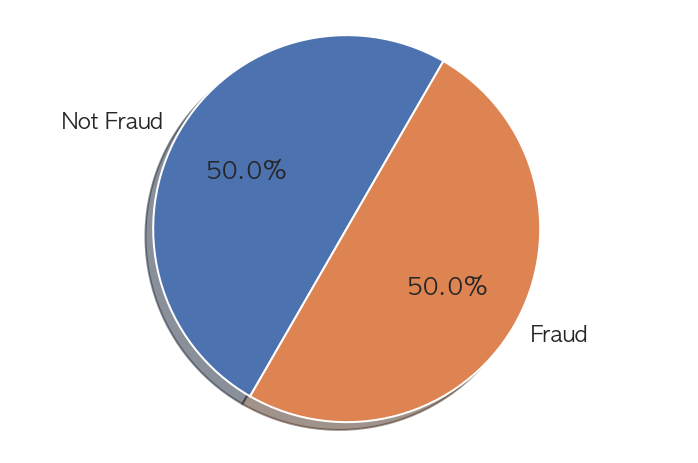

In [168]:
labels = 'Not Fraud', 'Fraud'
explode = (0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(y_adasyn.value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60)
ax1.axis('equal')
plt.show()

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_adasyn, y_adasyn, test_size = 0.10, random_state = 31)

In [92]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00      1328

    accuracy                           1.00      2570
   macro avg       1.00      1.00      1.00      2570
weighted avg       1.00      1.00      1.00      2570



0.9976653696498055

In [93]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.9976653696498055
precision 0.9977409638554217
recall 0.9977409638554217
f1 0.9977409638554217


In [94]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3109,    5],
       [   7,    0]])

In [95]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_val, y_pred))

print('precision', metrics.precision_score(y_val, y_pred))

print('recall', metrics.recall_score(y_val, y_pred))

print('f1', metrics.f1_score(y_val, y_pred))

정확도 : 0.9961550785004806
precision 0.0
recall 0.0
f1 0.0


In [96]:
# applying logistic regression
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter = 1000, random_state = 4)
log_clf.fit(X_train, y_train)
log_score = log_clf.score(X_test, y_test)
log_score

0.4463035019455253

## 복합 샘플링

- SMOTEENN: SMOTE + ENN
- SMOTETomek: SMOTE + Tomek

In [517]:
from imblearn.over_sampling import *

### SMOTETomek

In [97]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [98]:
from imblearn.combine import *
stt = SMOTETomek(random_state=4)
X_stt, y_stt = stt.fit_resample(X, y)

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_stt, y_stt, test_size = 0.10, random_state = 31)

In [100]:
len(X_stt), len(y_stt)

(22476, 22476)

In [16]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1118
           1       1.00      1.00      1.00      1130

    accuracy                           1.00      2248
   macro avg       1.00      1.00      1.00      2248
weighted avg       1.00      1.00      1.00      2248



0.998220640569395

In [17]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.998220640569395
precision 0.999113475177305
recall 0.9973451327433628
f1 0.9982285208148804


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_stt, y_stt)
 
# 예측
y_pred = forest.predict(X_test)
 
# 정확도 확인
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

print('precision', metrics.precision_score(y_test, y_pred))

print('recall', metrics.recall_score(y_test, y_pred))

print('f1', metrics.f1_score(y_test, y_pred))

정확도 : 1.0
precision 1.0
recall 1.0
f1 1.0


In [19]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3111,    3],
       [   7,    0]])

### SMOTEENN

In [101]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [102]:
from imblearn.combine import SMOTEENN 

sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X, y)

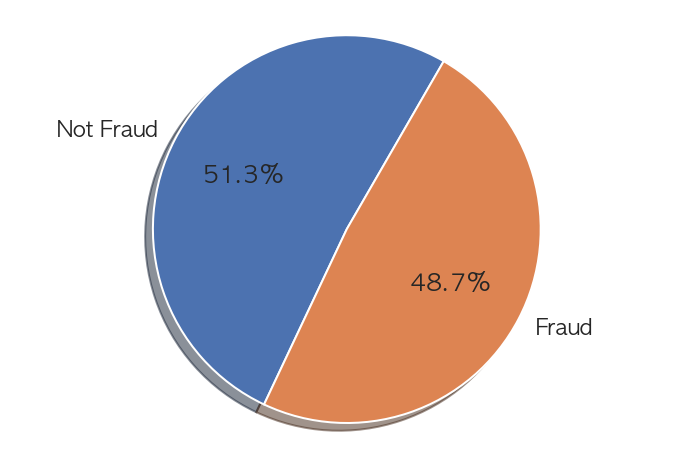

In [104]:
labels = 'Not Fraud', 'Fraud'
explode = (0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(y_sme.value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60)
ax1.axis('equal')
plt.show()

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_sme, y_sme, test_size = 0.10, random_state = 31)

In [106]:
len(X), len(y)

(12879, 12879)

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [108]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       851

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582



0.9987357774968394

In [110]:
# applying logistic regression
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter = 1000, random_state = 4)
log_clf.fit(X_train, y_train)
log_score = log_clf.score(X_test, y_test)
log_score

0.4595448798988622

In [111]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_test, y_preds))

print('precision', metrics.precision_score(y_test, y_preds))

print('recall', metrics.recall_score(y_test, y_preds))

print('f1', metrics.f1_score(y_test, y_preds))

정확도 : 0.9987357774968394
precision 0.9988249118683902
recall 0.9988249118683902
f1 0.9988249118683902


In [112]:
from sklearn.metrics import classification_report
y_preds = log_clf.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.37      0.23      0.28       731
           1       0.50      0.65      0.57       851

    accuracy                           0.46      1582
   macro avg       0.43      0.44      0.43      1582
weighted avg       0.44      0.46      0.44      1582



In [113]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3107,    7],
       [   7,    0]])

In [114]:
from sklearn import metrics    

print('정확도 :', metrics.accuracy_score(y_val, y_pred))

print('precision', metrics.precision_score(y_val, y_pred))

print('recall', metrics.recall_score(y_val, y_pred))

print('f1', metrics.f1_score(y_val, y_pred))

정확도 : 0.9955142582505607
precision 0.0
recall 0.0
f1 0.0


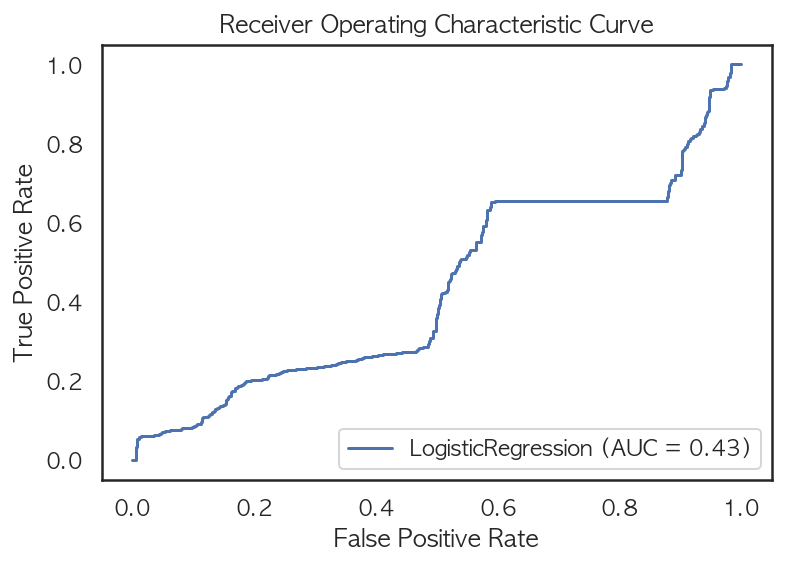

In [115]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(log_clf, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve');

In [116]:
## applying other models
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

models = []

models.append(("Random Forest Classifier: ", RandomForestClassifier()))
models.append(("Decision Tree Classifier: ", DecisionTreeClassifier()))
models.append(("AdaBoost Classifier: " , AdaBoostClassifier()))
models.append(("Gradient Boosting Classifier: ", GradientBoostingClassifier()))
models.append(("Logistic Regression: ", LogisticRegression()))

In [118]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)
    cv_results = cross_val_score(model, X_test, y_test,
                                cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)

    model = model.fit(X_test, y_test)
    y_preds = model.predict(X_test)

    print(name, cv_results.mean(), cv_results.std())
    print(classification_report(y_test, y_preds))    

Random Forest Classifier:  0.9822924569740048 0.005884670644426395
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       851

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582

Decision Tree Classifier:  0.9785029748832009 0.007855733591250903
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       851

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582

AdaBoost Classifier:  0.9468793674879208 0.01647964991370569
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       731
           1       0.94      0.99      0.9

In [ ]:
# Random Forest Classifier using SOTEENN

In [120]:
rfc = RandomForestClassifier(random_state = 4)
rfc.fit(X_test, y_test)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
log_score

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       851

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582



1.0

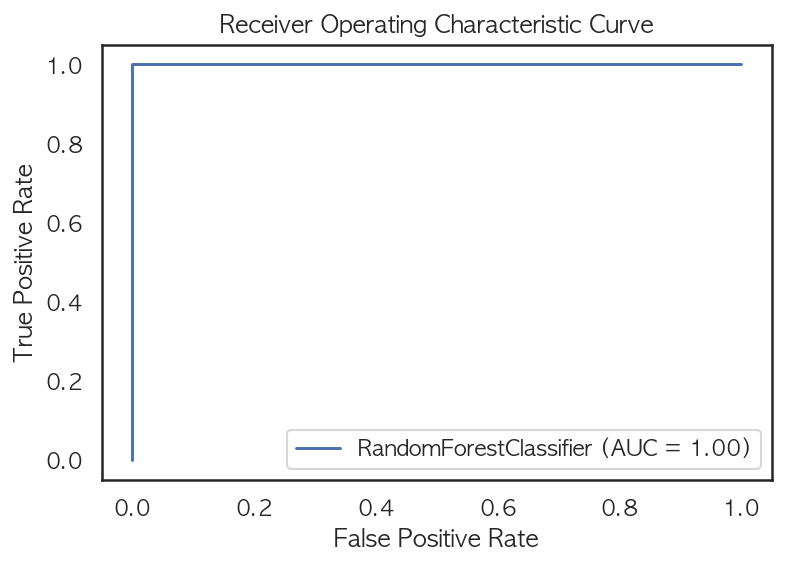

In [121]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rfc, X_test, y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve');

In [122]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[731,   0],
       [  0, 851]])

In [124]:
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3108,    6],
       [   7,    0]])

# 다른것도 만들어보기 

In [171]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [172]:
from imblearn.combine import SMOTEENN 

sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X, y)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_sme, y_sme, test_size = 0.10, random_state = 31)

In [176]:
len(X_sme), len(y_sme)

(15812, 15812)

In [174]:
# Gradient Boosting Classifier 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_clf = GradientBoostingClassifier(random_state=13)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print('Acc : ', accuracy_score(y_test, gb_pred))
print(classification_report(y_test, gb_pred))

Acc :  0.972819216182048
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       731
           1       0.96      0.99      0.98       851

    accuracy                           0.97      1582
   macro avg       0.97      0.97      0.97      1582
weighted avg       0.97      0.97      0.97      1582



In [175]:
gb_clf.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3108,    6],
       [   7,    0]])

In [184]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimator=400)
evals = [(X_val, y_val)]
lgbm.fit(X_train.values, y_train, early_stopping_rounds=10000, eval_set=evals)

[1]	valid_0's binary_logloss: 0.632454
Training until validation scores don't improve for 10000 rounds
[2]	valid_0's binary_logloss: 0.563842
[3]	valid_0's binary_logloss: 0.508568
[4]	valid_0's binary_logloss: 0.46106
[5]	valid_0's binary_logloss: 0.420045
[6]	valid_0's binary_logloss: 0.385691
[7]	valid_0's binary_logloss: 0.354865
[8]	valid_0's binary_logloss: 0.327688
[9]	valid_0's binary_logloss: 0.3046
[10]	valid_0's binary_logloss: 0.284649
[11]	valid_0's binary_logloss: 0.265598
[12]	valid_0's binary_logloss: 0.249888
[13]	valid_0's binary_logloss: 0.234943
[14]	valid_0's binary_logloss: 0.221254
[15]	valid_0's binary_logloss: 0.211239
[16]	valid_0's binary_logloss: 0.200725
[17]	valid_0's binary_logloss: 0.189231
[18]	valid_0's binary_logloss: 0.180896
[19]	valid_0's binary_logloss: 0.172926
[20]	valid_0's binary_logloss: 0.165398
[21]	valid_0's binary_logloss: 0.158196
[22]	valid_0's binary_logloss: 0.152593
[23]	valid_0's binary_logloss: 0.147721
[24]	valid_0's binary_loglos

LGBMClassifier(n_estimator=400)

In [185]:
lgbm.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[3108,    6],
       [   7,    0]])

AUTOENCODER - 'http://localhost:8888/notebooks/fastcampus/projects/Projects/ml/AUTOENCODER%20-Copy1.ipynb'

In [141]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# TO DO ANOMALY DETECTION 
- Perform anomaly detection, 
- Data need to divide by two grouop ("Normal", "various Attack ")

In [202]:
data = pd.read_csv("ins_fraud.csv")

In [203]:
val = data[data["c24"] == 1].drop("c24", 1)
data = data[data["c24"] == 0].drop("c24", 1)

In [204]:
# last column is the target
# 1 = anomaly, 0 = normal
TARGET = "fraud"

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]

In [205]:
normal_mask = data['fraud']== 0
attack_mask = data['fraud']== 1

data.drop('fraud',axis=1,inplace=True)



df_normal = data[normal_mask]
df_attack = data[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 12845
Attack count: 34


In [206]:
# Convert DataFrame into Numpy arrays, keras need numpy
x_normal = df_normal.values
x_attack = df_attack.values

## Training the Autoencoder 

In [190]:
from sklearn.model_selection import train_test_split

- important to note that we are not using the outcome column as a label to predict
- This anomaly detection is unsupervised
- **no target (y)**
- train an autoencoder on the normal data 
- see how well it can detect that the data not flagged as "normal" represents an anomaly

In [215]:
x_normal_train, x_normal_test = train_test_split(
    x_normal, test_size=0.3, random_state=77)

In [207]:
print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 11171
Normal test count: 4788


# How to learn?

- The autoencoder will learn to compress the data to a vector of just three numbers
- autoencoder should be able to also decompress with reasonable accuracy

In [208]:
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [209]:
model = AutoEncoder(output_units=x_normal_train.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_normal_train,
    x_normal_train,
    epochs=100,
    batch_size=512,
    validation_data=(x_normal_test, x_normal_test)
)

Epoch 1/100
22/22 [==============================] - 1s 10ms/step - loss: 7.4937 - mse: 423447166976.0000 - val_loss: 7.3063 - val_mse: 493758545920.0000
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 7.3599 - mse: 423447199744.0000 - val_loss: 7.2572 - val_mse: 493758545920.0000
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 7.3165 - mse: 423447199744.0000 - val_loss: 7.2253 - val_mse: 493758545920.0000
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 7.2883 - mse: 423447199744.0000 - val_loss: 7.2098 - val_mse: 493758545920.0000
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 7.2342 - mse: 423447166976.0000 - val_loss: 7.1951 - val_mse: 493758545920.0000
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 7.1878 - mse: 423447199744.0000 - val_loss: 7.1610 - val_mse: 493758545920.0000
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 7.1476 -

22/22 [==============================] - 0s 4ms/step - loss: 7.1013 - mse: 423447166976.0000 - val_loss: 7.1158 - val_mse: 493758545920.0000
Epoch 55/100
22/22 [==============================] - 0s 4ms/step - loss: 7.1020 - mse: 423447101440.0000 - val_loss: 7.1158 - val_mse: 493758545920.0000
Epoch 56/100
22/22 [==============================] - 0s 3ms/step - loss: 7.1021 - mse: 423447101440.0000 - val_loss: 7.1158 - val_mse: 493758545920.0000
Epoch 57/100
22/22 [==============================] - 0s 4ms/step - loss: 7.1019 - mse: 423447101440.0000 - val_loss: 7.1158 - val_mse: 493758545920.0000
Epoch 58/100
22/22 [==============================] - 0s 5ms/step - loss: 7.1020 - mse: 423447166976.0000 - val_loss: 7.1157 - val_mse: 493758545920.0000
Epoch 59/100
22/22 [==============================] - 0s 5ms/step - loss: 7.1019 - mse: 423447166976.0000 - val_loss: 7.1157 - val_mse: 493758545920.0000
Epoch 60/100
22/22 [==============================] - 0s 4ms/step - loss: 7.1022 - mse: 4

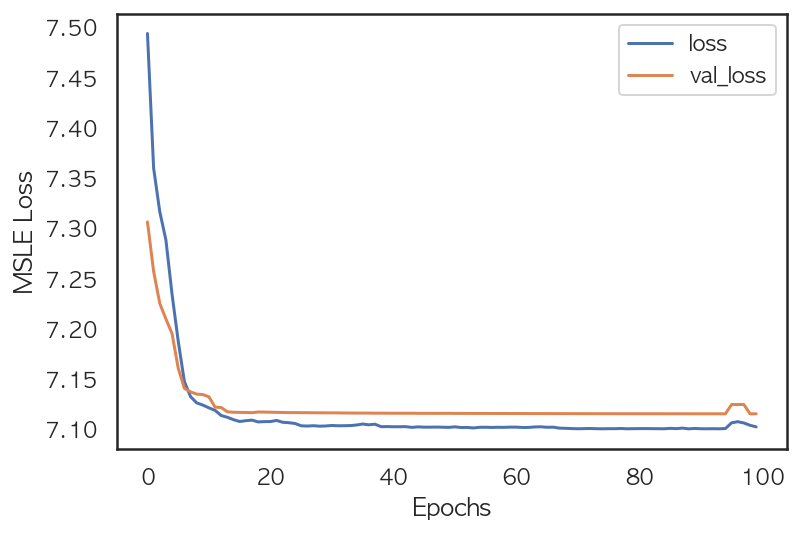

In [210]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Detecting an Anomaly 

- encoding data that represents an attack. This higher error indicates an anomaly.

In [216]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test))
pred = model.predict(normal_mask)
score2 = np.sqrt(metrics.mean_squared_error(pred,normal_mask))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_attack))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Anormal Data (RMSE): {score3}")

ValueError: in user code:

    /Users/sunny/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    <ipython-input-143-10a22babf697>:34 call  *
        encoded = self.encoder(inputs)
    /Users/sunny/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/sunny/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (None, 23)


In [217]:
def find_threshold(model, x_train):
  reconstructions = model.predict(x_train)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test, threshold):
  predictions = model.predict(x_test)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

In [218]:
threshold = find_threshold(model, x_normal_train)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test, threshold)
accuracy_score(y_test, predictions)

ValueError: in user code:

    /Users/sunny/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    <ipython-input-143-10a22babf697>:34 call  *
        encoded = self.encoder(inputs)
    /Users/sunny/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/sunny/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (None, 23)


In [199]:
confusion_matrix(y_test, predictions)

array([[2487,  705],
       [   6,    2]])

In [ ]:
#  맞췄당 

# Autoencoder Scaled

In [31]:
data = pd.read_csv("ins_fraud.csv")

In [32]:
x_normal = data[data["fraud"]==0].values
x_attack = data[data["fraud"]==1].values

In [25]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = "fraud"

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [26]:
# create a model by subclassing Model class in tensorflow

model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/100
25/25 [==============================] - 1s 9ms/step - loss: 0.1114 - mse: 0.1894 - val_loss: 0.0960 - val_mse: 0.1632
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 0.0672 - mse: 0.1236 - val_loss: 0.0504 - val_mse: 0.1030
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0504 - mse: 0.1007 - val_loss: 0.0458 - val_mse: 0.0931
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0467 - mse: 0.0941 - val_loss: 0.0433 - val_mse: 0.0886
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0442 - mse: 0.0898 - val_loss: 0.0419 - val_mse: 0.0859
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0427 - mse: 0.0872 - val_loss: 0.0407 - val_mse: 0.0839
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0412 - mse: 0.0848 - val_loss: 0.0389 - val_mse: 0.0807
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.0393 - m

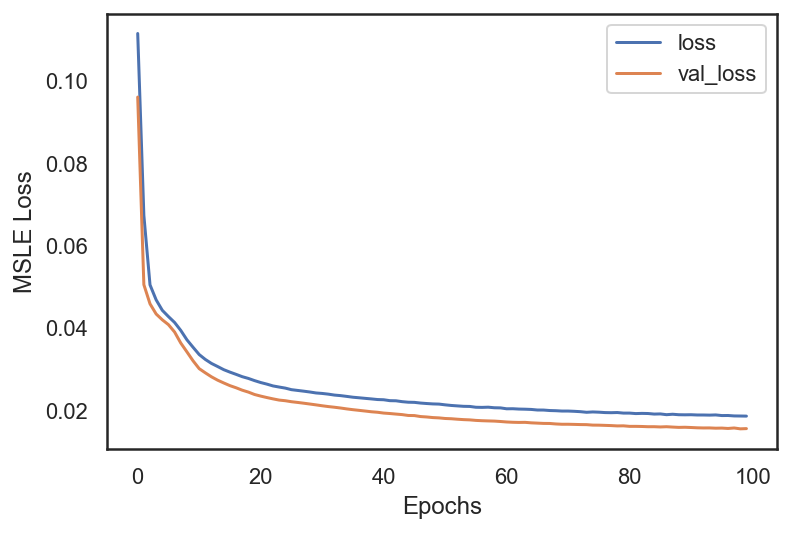

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [28]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

Threshold: 0.025185821743867194


0.818125

In [29]:
confusion_matrix(y_test, predictions)

array([[2618,  574],
       [   8,    0]])

# 다시 해보기 z-score 맞춰서  

In [133]:
data = pd.read_csv("ins_fraud.csv")

In [134]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    
    data[name] = (df[name] - mean) / sd

In [135]:
val = data[data["c24"] == 1].drop("c24", 1)
data = data[data["c24"] == 0].drop("c24", 1)

In [136]:
encode_numeric_zscore(data, "c14")
encode_numeric_zscore(data, "c15")
encode_numeric_zscore(data, "c7")
encode_numeric_zscore(data, "c19")

In [137]:
data

,fraud,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
0,0,2,1,3,0,2,0,0.367910,2,0,...,-0.296576,-0.273436,1,0,0,-0.382013,0,0,0,-1
3,0,3,1,3,0,4,0,-3.009365,2,0,...,2.047547,-0.273436,3,1,0,-0.382013,0,0,0,-1
4,0,1,0,1,0,1,0,0.367910,1,0,...,0.465808,0.121305,1,0,0,0.672864,0,0,0,-1
6,1,1,1,3,0,4,0,0.367910,3,0,...,-0.548760,0.123874,0,0,0,-0.382013,1,2,1,2
8,0,2,0,4,0,4,0,-3.009365,1,0,...,-0.548760,-0.273436,1,0,0,-0.382013,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15994,0,2,0,3,1,4,0,0.367910,1,0,...,0.743176,-0.273436,0,0,0,-0.382013,0,0,0,-1
15995,0,2,0,2,0,2,0,0.367910,2,0,...,-0.548760,-0.273436,1,1,0,-0.382013,0,0,0,-1
15996,0,2,0,2,1,4,0,0.367910,1,1,...,0.648591,-0.273436,2,1,0,-0.382013,0,0,0,-1
15998,0,2,0,2,0,2,0,0.367910,2,0,...,-0.548760,-0.273436,4,1,0,-0.382013,0,0,0,-1


In [138]:
# last column is the target
# 1 = anomaly, 0 = normal
TARGET = "fraud"

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

normal_mask = data['fraud']== 0
attack_mask = data['fraud']== 1

data.drop('fraud',axis=1,inplace=True)



df_normal = data[normal_mask]
df_attack = data[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 12845
Attack count: 34


In [139]:
x_normal = df_normal.values
x_attack = df_attack.values

In [144]:
# create a model by subclassing Model class in tensorflow

model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/100
21/21 [==============================] - 1s 11ms/step - loss: 0.1086 - mse: 0.1846 - val_loss: 0.0925 - val_mse: 0.1587
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0679 - mse: 0.1243 - val_loss: 0.0469 - val_mse: 0.0954
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0475 - mse: 0.0949 - val_loss: 0.0433 - val_mse: 0.0865
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0440 - mse: 0.0883 - val_loss: 0.0408 - val_mse: 0.0833
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0418 - mse: 0.0845 - val_loss: 0.0392 - val_mse: 0.0800
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0401 - mse: 0.0817 - val_loss: 0.0381 - val_mse: 0.0781
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0389 - mse: 0.0796 - val_loss: 0.0368 - val_mse: 0.0760
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0375 - 

21/21 [==============================] - 0s 5ms/step - loss: 0.0190 - mse: 0.0389 - val_loss: 0.0159 - val_mse: 0.0328
Epoch 64/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0188 - mse: 0.0386 - val_loss: 0.0159 - val_mse: 0.0327
Epoch 65/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0188 - mse: 0.0386 - val_loss: 0.0159 - val_mse: 0.0326
Epoch 66/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0188 - mse: 0.0385 - val_loss: 0.0158 - val_mse: 0.0325
Epoch 67/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0187 - mse: 0.0382 - val_loss: 0.0158 - val_mse: 0.0324
Epoch 68/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0187 - mse: 0.0383 - val_loss: 0.0158 - val_mse: 0.0324
Epoch 69/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0186 - mse: 0.0381 - val_loss: 0.0158 - val_mse: 0.0323
Epoch 70/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0187 - mse: 0

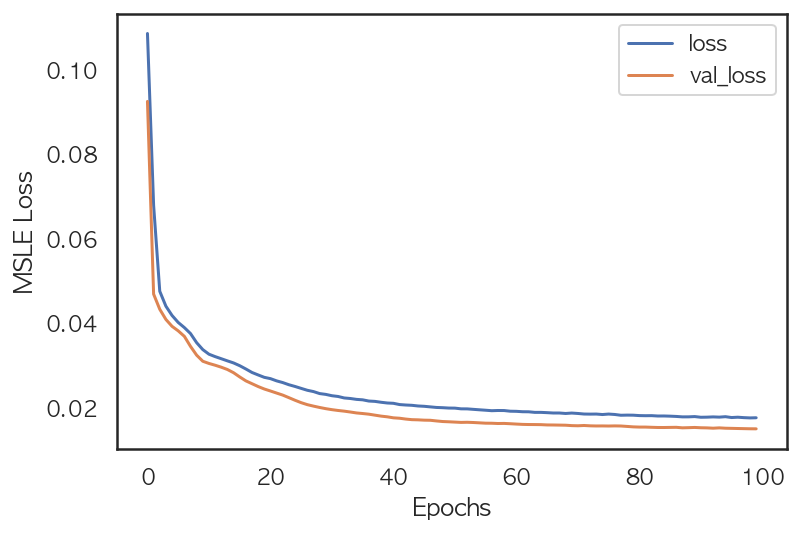

In [145]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [148]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

Threshold: 0.024753206825946356


0.8156055900621118

In [149]:
confusion_matrix(y_test, predictions)

array([[2099,  470],
       [   5,    2]])

In [ ]:
# enro 맞췄당

In [154]:
pred = model.predict(x_test_scaled)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_test_scaled))
pred = model.predict(x_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_normal))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_attack))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Anormal Data (RMSE): {score3}")

Out of Sample Normal Score (RMSE): 0.17482059978341527
Insample Normal Score (RMSE): 1.520574428573462
Anormal Data (RMSE): 1.4606848936831112


# SMOTE를 쓴 다음 AUTOENCODER 

In [155]:
data = pd.read_csv("ins_fraud.csv")

In [156]:
val = data[data["c24"] == 1].drop("c24", 1)
data = data[data["c24"] == 0].drop("c24", 1)

In [3]:
data

,fraud,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
0,0,2,1,3,0,2,0,100,2,0,...,1.302547e+05,0,1,0,0,1,0,0,0,-1
3,0,3,1,3,0,4,0,0,2,0,...,1.341009e+06,0,3,1,0,1,0,0,0,-1
4,0,1,0,1,0,1,0,100,1,0,...,5.240306e+05,1209410,1,0,0,2,0,0,0,-1
6,1,1,1,3,0,4,0,100,3,0,...,0.000000e+00,1217280,0,0,0,1,1,2,1,2
8,0,2,0,4,0,4,0,0,1,0,...,0.000000e+00,0,1,0,0,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15994,0,2,0,3,1,4,0,100,1,0,...,6.672931e+05,0,0,0,0,1,0,0,0,-1
15995,0,2,0,2,0,2,0,100,2,0,...,0.000000e+00,0,1,1,0,1,0,0,0,-1
15996,0,2,0,2,1,4,0,100,1,1,...,6.184394e+05,0,2,1,0,1,0,0,0,-1
15998,0,2,0,2,0,2,0,100,2,0,...,0.000000e+00,0,4,1,0,1,0,0,0,-1


In [4]:
X = data.drop("fraud", 1)
y = data[["fraud"]]

In [5]:
from imblearn.combine import SMOTEENN 

sme = SMOTEENN(random_state=42)
X_sme, y_sme  = sme.fit_resample(X, y)

In [10]:
len(X_sme), len(y_sme)

(15812, 15812)

In [14]:
data = pd.concat([X_sme, y_sme], 1)

In [16]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    
    data[name] = (df[name] - mean) / sd

In [17]:
encode_numeric_zscore(data, "c14")
encode_numeric_zscore(data, "c15")
encode_numeric_zscore(data, "c7")
encode_numeric_zscore(data, "c19")

In [18]:
data

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c15,c16,c17,c18,c19,c20,c21,c22,c23,fraud
0,2,1,3,0,2,0,0.309908,2,0,0,...,-0.300037,1,0,0,-0.277896,0,0,0,-1,0
1,1,0,1,0,1,0,0.309908,1,0,0,...,0.113277,1,0,0,1.116169,0,0,0,-1,0
2,2,0,4,0,4,0,-3.617682,1,0,0,...,-0.300037,1,0,0,-0.277896,1,1,1,2,0
3,1,0,5,0,3,0,0.309908,2,0,0,...,-0.300037,0,0,0,-0.277896,0,0,0,-1,0
4,1,1,1,0,1,0,-3.617682,1,0,0,...,-0.300037,1,1,0,-0.277896,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15807,3,0,2,0,4,0,0.309908,2,0,0,...,-0.146796,0,0,0,-0.277896,0,0,0,0,1
15808,2,0,1,0,2,0,0.309908,1,0,0,...,0.110372,1,0,0,-0.277896,0,0,0,1,1
15809,2,0,3,0,2,0,0.309908,2,0,0,...,0.021133,1,0,0,-0.277896,1,2,1,0,1
15810,2,0,2,0,3,0,0.309908,1,0,0,...,-0.149760,0,0,0,-0.277896,0,0,0,0,1


In [19]:
normal_mask = data['fraud']== 0
attack_mask = data['fraud']== 1

data.drop('fraud',axis=1,inplace=True)


df_normal = data[normal_mask]
df_attack = data[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 7698
Attack count: 8114


In [20]:
# Convert DataFrame into Numpy arrays, keras need numpy
x_normal = df_normal.values
x_attack = df_attack.values

In [23]:
df_normal = x_normal
df_attack = x_attack

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 7698
Attack count: 8114


In [29]:
from sklearn.model_selection import train_test_split 

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.2, random_state=13)

In [30]:
print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 6158
Normal test count: 1540


In [ ]:
model = Sequential()
model.add(Dense(25, input_dim=x_normal.shape[1], activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to

model.add(Dense(25, activation='relu'))
model.add(Dense(x_normal.shape[1])) # Multiple output neurons

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

In [41]:
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


In [43]:
model = AutoEncoder(output_units=x_normal_train.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_normal_train,
    x_normal_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_attack, x_attack)
)

Epoch 1/20
13/13 [==============================] - 1s 16ms/step - loss: 0.3320 - mse: 2.5131 - val_loss: 0.2262 - val_mse: 1.3614
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 0.2549 - mse: 2.1716 - val_loss: 0.1548 - val_mse: 1.0818
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.2062 - mse: 1.9460 - val_loss: 0.1376 - val_mse: 1.0280
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1985 - mse: 1.9184 - val_loss: 0.1380 - val_mse: 1.0290
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1969 - mse: 1.9165 - val_loss: 0.1365 - val_mse: 1.0267
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1954 - mse: 1.9138 - val_loss: 0.1356 - val_mse: 1.0272
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.1941 - mse: 1.9169 - val_loss: 0.1351 - val_mse: 1.0279
Epoch 8/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1925 - mse: 1.9

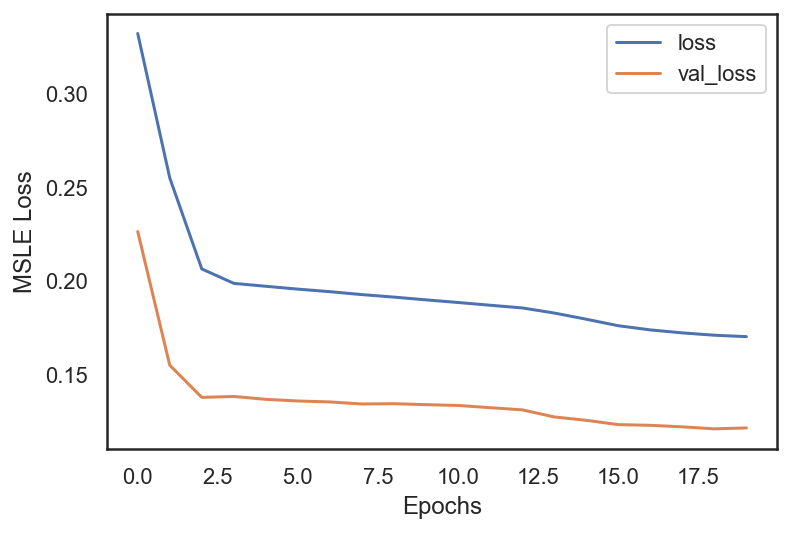

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [45]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test))
pred = model.predict(x_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_normal))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_attack))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Anormal Data (RMSE): {score3}")

Out of Sample Normal Score (RMSE): 1.3590896828443877
Insample Normal Score (RMSE): 1.3523096577380722
Anormal Data (RMSE): 0.9892187955411343


# CLUSTERING 해보자 

In [25]:
data = pd.read_csv("ins_fraud.csv")

In [26]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    
    data[name] = (df[name] - mean) / sd

In [27]:
val = data[data["c24"] == 1].drop("c24", 1)
data = data[data["c24"] == 0].drop("c24", 1)

In [28]:
encode_numeric_zscore(data, "c14")
encode_numeric_zscore(data, "c15")
encode_numeric_zscore(data, "c7")
encode_numeric_zscore(data, "c19")

In [29]:
data

,fraud,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
0,0,2,1,3,0,2,0,0.367910,2,0,...,-0.296576,-0.273436,1,0,0,-0.382013,0,0,0,-1
3,0,3,1,3,0,4,0,-3.009365,2,0,...,2.047547,-0.273436,3,1,0,-0.382013,0,0,0,-1
4,0,1,0,1,0,1,0,0.367910,1,0,...,0.465808,0.121305,1,0,0,0.672864,0,0,0,-1
6,1,1,1,3,0,4,0,0.367910,3,0,...,-0.548760,0.123874,0,0,0,-0.382013,1,2,1,2
8,0,2,0,4,0,4,0,-3.009365,1,0,...,-0.548760,-0.273436,1,0,0,-0.382013,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15994,0,2,0,3,1,4,0,0.367910,1,0,...,0.743176,-0.273436,0,0,0,-0.382013,0,0,0,-1
15995,0,2,0,2,0,2,0,0.367910,2,0,...,-0.548760,-0.273436,1,1,0,-0.382013,0,0,0,-1
15996,0,2,0,2,1,4,0,0.367910,1,1,...,0.648591,-0.273436,2,1,0,-0.382013,0,0,0,-1
15998,0,2,0,2,0,2,0,0.367910,2,0,...,-0.548760,-0.273436,4,1,0,-0.382013,0,0,0,-1


In [31]:
y = data["fraud"]

In [9]:
normal_mask = data['fraud']== 0
attack_mask = data['fraud']== 1

In [10]:
data.drop('fraud',axis=1,inplace=True)


df_normal = data[normal_mask]
df_attack = data[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 12845
Attack count: 34


In [14]:
x_normal = df_normal.values
x_attack = df_attack.values

In [32]:
X_train, X_test = train_test_split(X_normal, test_size = 0.2, random_state = 13)
y_train, y_test  = train_test_split(y, test_size = 0.2, random_state = 13)

In [33]:
model = Sequential()
model.add(Dense(25, input_dim=x_normal.shape[1], activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to

model.add(Dense(25, activation='relu'))
model.add(Dense(x_normal.shape[1])) # Multiple output neurons

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
model.fit(X_train, X_train, epochs=100, batch_size=256)

Epoch 1/100
41/41 [==============================] - 0s 982us/step - loss: 3.0539
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 2.0206
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.9603
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.7856
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.7340
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6723
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6380
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6212
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6113
Epoch 10/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6039
Epoch 11/100
41/41 [==============================] - 0s 985us/step - loss: 0.5945
Epoch 12/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5813
Epoch 13/100
41/41 [=============

In [34]:
# 잠재 변수 벡터 확보 
latent_vector_model = tf.keras.Model(inputs=model.input, outputs=model.layers[3].output)
latent_vector = latent_vector_model.predict(X_train)
print(latent_vector.shape)
print(latent_vector[0])

(10276, 23)
[ 1.7594583   0.1239159   2.7655616   0.16113791  3.3853838   0.04493888
  0.16853644  1.9224554   0.18499725  0.04745646  1.8386053   2.2963243
  1.1570385  -0.04096618 -0.08832107  1.2204677   0.2727028   0.18647322
  0.07316293  0.06855031  0.05238083  0.04102389 -1.0742863 ]


In [35]:
%%time 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init=10, random_state=13)
kmeans.fit(latent_vector)

CPU times: user 1.82 s, sys: 490 ms, total: 2.31 s
Wall time: 361 ms


KMeans(n_clusters=10, random_state=13)

In [36]:
# 군집 결과 
print(kmeans.labels_)
print(kmeans.cluster_centers_.shape)
print(kmeans.cluster_centers_[0])

[8 8 4 ... 2 1 8]
(10, 23)
[ 1.553015    0.11793122  1.8242129   0.09678217  2.378882    0.01862649
 -0.13263474  1.6938002   0.15574399  0.12232585  2.043911    1.8587477
  1.8370966   0.06029006  0.6368396   0.77004033  0.41895756  0.12679003
  0.11741614  0.81008995  0.93266845  0.7549746   0.70214903]


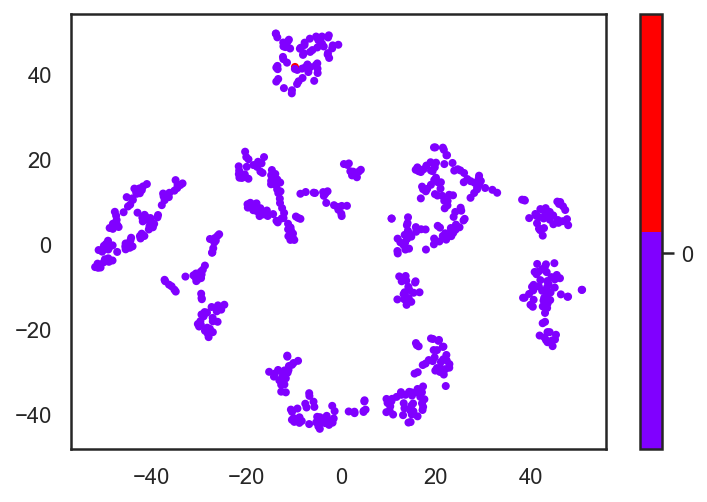

CPU times: user 11.3 s, sys: 579 ms, total: 11.9 s
Wall time: 1.87 s


In [40]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=13)
tsne_vector = tsne.fit_transform(latent_vector[:621])

cmap = plt.get_cmap('rainbow', 2)
fig = plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=y_train[:621], cmap=cmap)
cb = plt.colorbar(fig, ticks=range(10))
n_clusters = 10
tick_locs = (np.arange(n_clusters) + 0.5) * (n_clusters-1) / n_clusters
cb.set_ticks(tick_locs)
cb.set_ticklabels(range(10))

plt.show()

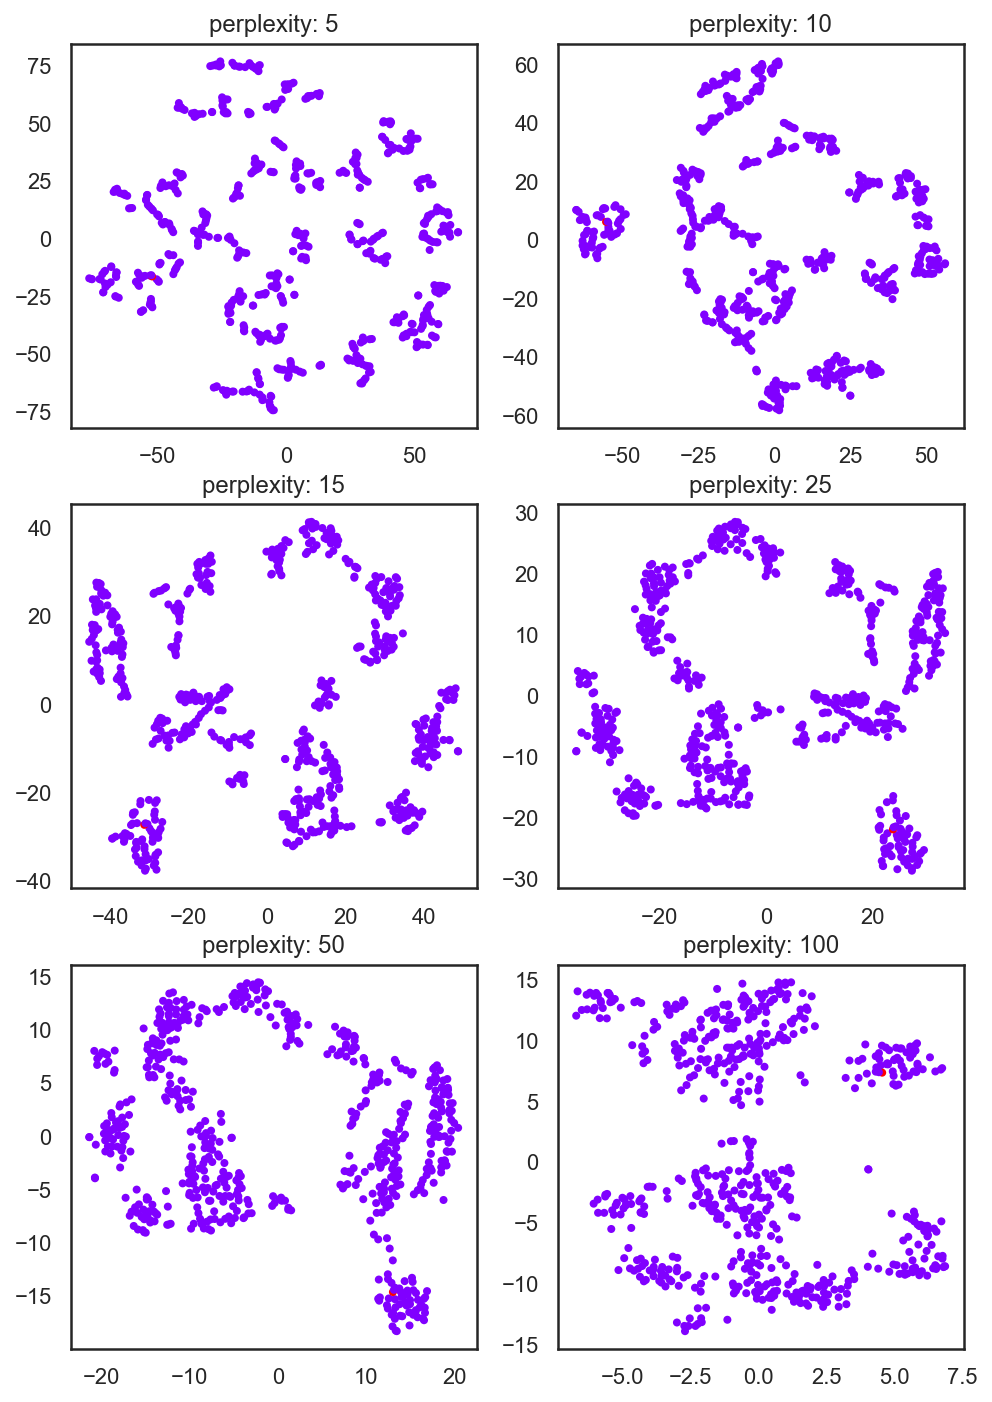

In [39]:
# 최근접이웃의 숫자 perplexities tuning 
perplexities = [5, 10, 15, 25, 50, 100]
plt.figure(figsize=(8, 12))

for c in range(6):
    tsne = TSNE(n_components=2, learning_rate=100, perplexity=perplexities[c], random_state=0)
    tsne_vector = tsne.fit_transform(latent_vector[:621])
    
    plt.subplot(3, 2, c+1)
    plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker='.', c=y_train[:621], cmap='rainbow')
    plt.title('perplexity: {0}'.format(perplexities[c]))
plt.show()

In [ ]:
# 원 데아터가 있으면 clustering이라는 컬럼을 만들어서 번호를 붙여주고 fraud데이터ㄴ에 어떤 번호가 붙어있는지 확인 
# 예제 찾아보거나 노력... 

# Feature Importance

SMOTEENN and random forest classification

In [221]:
data = pd.read_csv("ins_fraud.csv")

In [222]:
X = data[data["c24"] == 0].drop(["c24", "fraud"], 1)
y = data[data["c24"] == 0][["fraud"]]
X_val = data[data["c24"] == 1].drop(["c24", "fraud"], 1)
y_val = data[data["c24"] == 1][["fraud"]]

In [223]:
from imblearn.combine import SMOTEENN 

sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(X, y)

In [224]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_sme, y_sme, test_size = 0.10, random_state = 31)

In [225]:
rfc = RandomForestClassifier(random_state = 13)
rfc.fit(X_train, y_train)
log_score = rfc.score(X_test, y_test)
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       1.00      1.00      1.00       851

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582



In [253]:
importances = rfc.feature_importances_
importances

array([0.041252  , 0.0243385 , 0.0557005 , 0.00587669, 0.06768333,
       0.00039635, 0.03345421, 0.02711708, 0.01441799, 0.00235178,
       0.06465235, 0.04725187, 0.09423573, 0.05942476, 0.06440832,
       0.09131623, 0.03252952, 0.04621617, 0.04919618, 0.02092391,
       0.01890437, 0.02035393, 0.11799823])

In [254]:
feature_importances = pd.DataFrame(rfc.feature_importances_, index = datas.columns, 
                                  columns = ["importance"]).sort_values("importance", ascending=False)

In [245]:
datas = data.drop(["fraud", "c24"], 1)

In [255]:
feature_importances

,importance
c23,0.117998
c13,0.094236
c16,0.091316
c5,0.067683
c11,0.064652
c15,0.064408
c14,0.059425
c3,0.055700
c19,0.049196
c12,0.047252


Text(0.5, 1.0, 'feature importances')

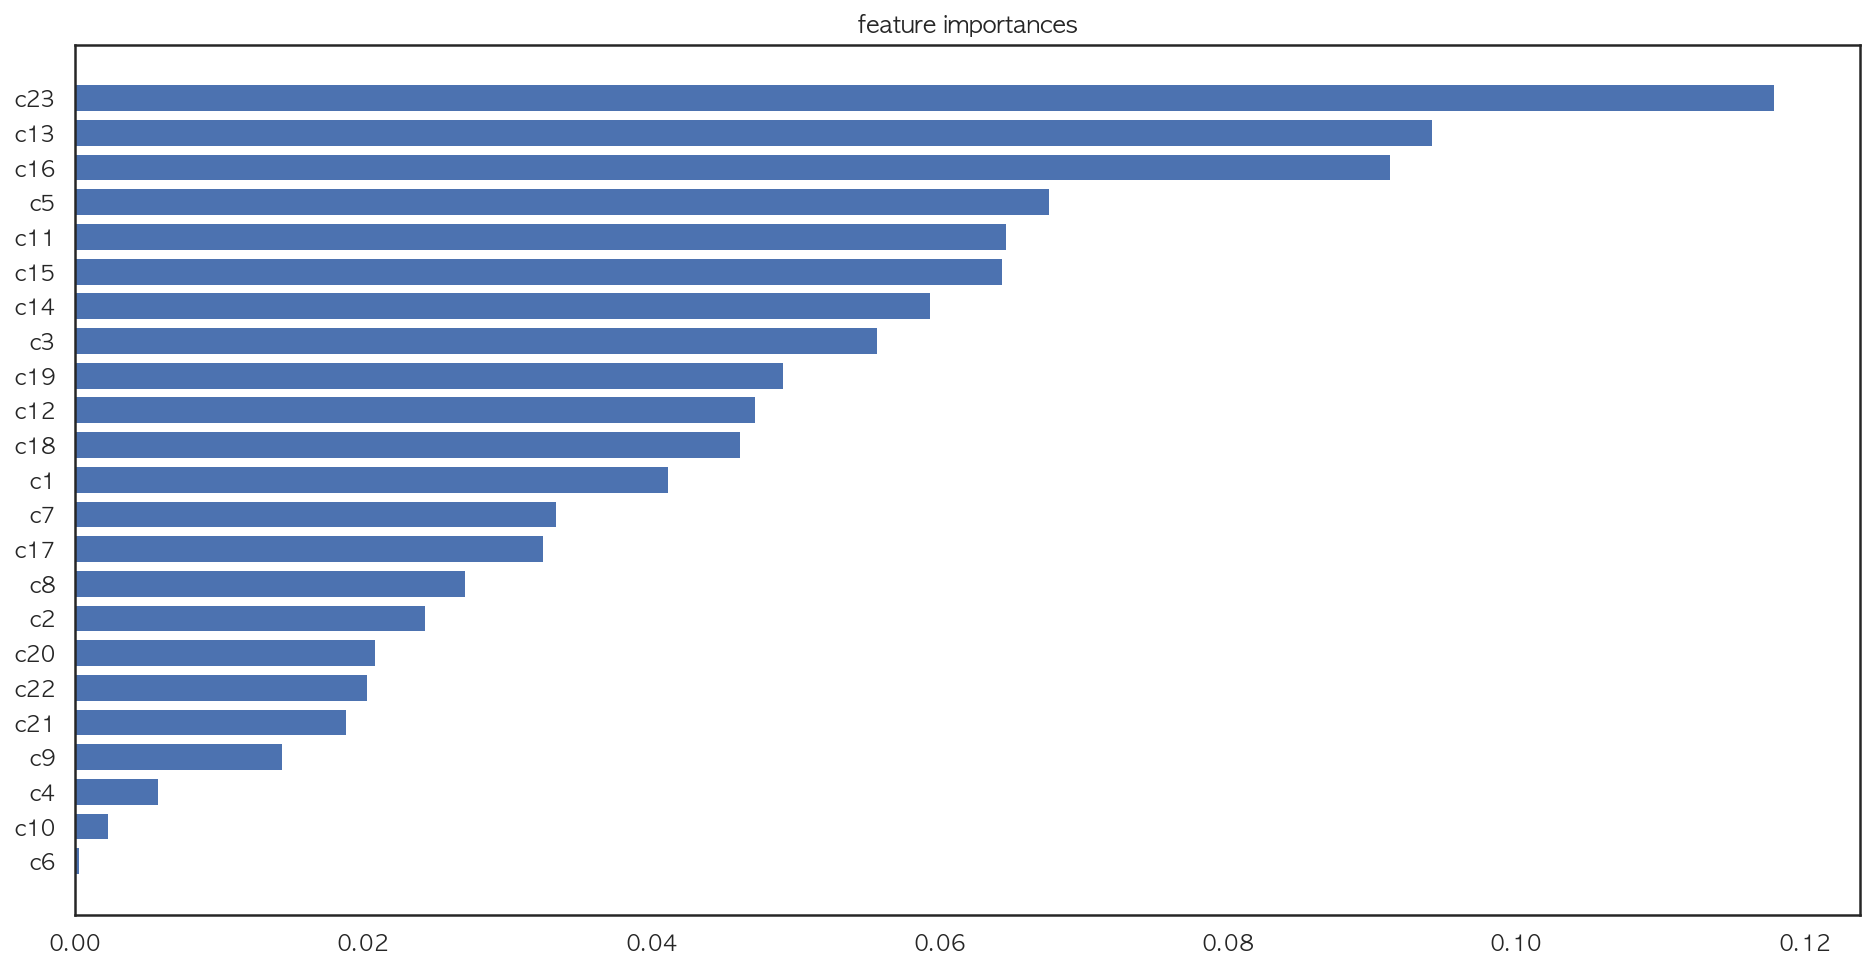

In [258]:
plt.figure(figsize=(16,8))
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.title("feature importances")

<Figure size 1152x864 with 0 Axes>

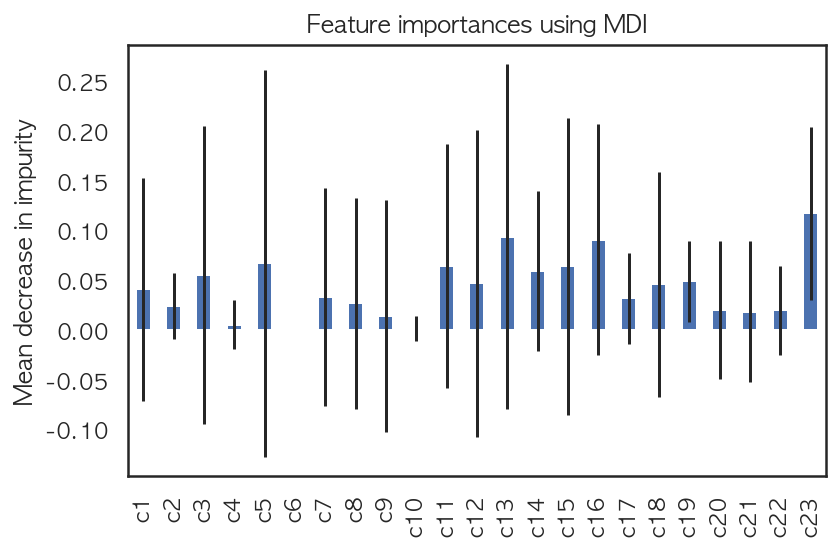

In [252]:
forest_importances = pd.Series(importances, index=datas.columns)

plt.figure(figsize=(16, 12))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()